# CS 229: Problem Set 1

## Problem 1: Linear Classifiers (Logistic Regression and GDA)

### a)

Consider the average empirical loss function for a logistic regression: 

\begin{equation}
\text{J}(\theta) = -\frac{1}{m}\sum_{i=1}^my^{(i)} \ \text{log}(h_{\theta}(x^{(i)})) \ + \ (1-y^{(i)}) \ \text{log}(1-h_{\theta}(x^{(i)}))
\end{equation}

where $y^{(i)} \in \{0,1\}$, $h_{\theta}(x^{(i)}) = \text{g}(\theta^Tx^{(i)})$ and $\text{g}(z) = 1/(1 + e^{-\theta^Tz})$. To derive the Hessian matrix, we first start out by computing the gradient of the loss function. 
\begin{align*}
\nabla_{\theta} \text{J}(\theta) 
&= -\frac{1}{m}\sum_{i=1}^m 
   \frac{y^{(i)}}{h_{\theta}(x^{(i)})} 
   \, h_{\theta}(x^{(i)})\bigl(1 - h_{\theta}(x^{(i)})\bigr)x^{(i)} - 
   \frac{(1 - y^{(i)})}{1 - h_{\theta}(x^{(i)})}
   \, h_{\theta}(x^{(i)})\bigl(1 - h_{\theta}(x^{(i)})\bigr)x^{(i)} \\
&= -\frac{1}{m}\sum_{i=1}^m y^{(i)}\bigl(1 - h_{\theta}(x^{(i)})\bigr)x^{(i)}-(1 - y^{(i)})h_{\theta}(x^{(i)})x^{(i)}\\
&=-\frac{1}{m}\sum_{i=1}^m(y^{(i)}-h_{\theta}(x^{(i)}))x^{(i)}
\end{align*}

thus, the Hessian matrix is 
\begin{align*}
\nabla_{\theta}^2 \text{J}(\theta) 
&= \frac{1}{m}\sum_{i=1}^m(h_{\theta}(x^{(i)})(1-h_{\theta}(x^{(i)})))x^{(i)}(x^{(i)})^T
\end{align*}

We now prove that the Hessian matrix of the loss function is positive semidefinite. Formally, given any vector $z \in R^n$, then $z^THz \geq 0$. We start out by noting that 

\begin{equation}
\sum_i\sum_jz_ix_ix_jz_j = (x^Tz)^2 \geq 0
\end{equation}

thus, 

\begin{align*}
z^THz 
&= \sum_{k = 1}^n\sum_{j=1}^n
z_kz_jH_{jk} \\
&= \sum_{k = 1}^n\sum_{j=1}^n
z_kz_j\frac{1}{m}\sum_{i=1}^m(h_{\theta}(x^{(i)})(1-h_{\theta}(x^{(i)})))x^{(i)}_jx^{(i)}_k \\
&= \frac{1}{m}\sum_{i=1}^m(h_{\theta}(x^{(i)})(1-h_{\theta}(x^{(i)})))\sum_{k = 1}^n\sum_{j=1}^n
z_kz_jx^{(i)}_jx^{(i)}_k \\
&=\frac{1}{m}\sum_{i=1}^m(h_{\theta}(x^{(i)})(1-h_{\theta}(x^{(i)})))((x^{(i)})^Tz)^2 \\
&\geq 0
\end{align*}

This implies that the average empirical loss function is convex, which means that there are no local minima except for the global one.

### b)

In [1]:
import numpy as np
import util
import matplotlib.pyplot as plt

from linear_model import LinearModel

We import the training and test sets provided for.

In [2]:
train_path = "ds1_train.csv"
eval_path = "ds1_valid.csv"

In [3]:
x_train, y_train = util.load_dataset(train_path, add_intercept=True)
x_eval, y_eval = util.load_dataset(eval_path, add_intercept=True)

In [4]:
x_train

array([[  1.        ,   2.91180854,  60.35961272],
       [  1.        ,   3.77474554, 344.1492843 ],
       [  1.        ,   2.61548828, 178.22208681],
       ...,
       [  1.        ,   2.96909526,  20.24997848],
       [  1.        ,   3.95753102,  27.26196973],
       [  1.        ,   4.02533402,  12.23316511]])

In [5]:
#y_train

We plot the training set for visualization purposes and data exploration.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


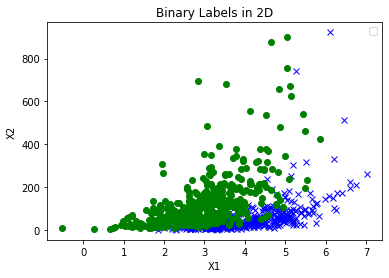

In [6]:
plt.plot(x_train[y_train == 1, -2], x_train[y_train == 1, -1], 'bx', linewidth=2)
plt.plot(x_train[y_train == 0, -2], x_train[y_train == 0, -1], 'go', linewidth=2)
plt.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Binary Labels in 2D")
plt.show()

We now define our Logistic Regression Class that uses the Newton's Method to minimize the average empirical loss and update the model parameters.

In [7]:
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """
    
    def linear_input(self, x, theta):
        """Computes liner combination of theta and feature vector.
        
        Args:
            x: Training example inputs. Shape (m, n).
            theta: weight parameters. Shape (n,1).
        """
        return x @ theta
    
    
    def net_input(self, z):
        """Applies the Sigmoid Function to linear input z.
        
        Args:
            z: linear input. Shape (m,1).
        """
        return 1 / (1 + np.exp(-z))
    
    
    def average_empirical_loss(self, sigma, y, m):
        """Computes the average empirical loss of the Logistic Regression.
        
        Args:
            sigma: The net input. Shape (m,1).
            y: Training example labels. Shape (m,1).
            m: Number of traning examples.
        Output:
            Average empirical loss.
        """
        epsilon = 1e-15
        sigma = np.clip(sigma, epsilon, 1 - epsilon)
        return -(1/m) * np.sum(y * np.log(sigma) + (1 - y) * np.log(1 - sigma))
    
    
    def gradient(self, x, y, sigma, m):
        """Computes the gradient of the loss function.
        
        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,1).
            sigma: The net input. Shape (m,1).
            m: Number of traning examples.
        Output
            Gradient vector. Shape (n,1)
        """
        return -(1/m) * (x.T @ (y - sigma))
    
    
    def hessian_matrix(self, x, sigma, m):
        """Computes the Hessian Matrix of the loss function.
        
        Args:
            x: Training example inputs. Shape (m, n).
            sigma: The net input. Shape (m,1).
            m: Number of traning examples.
        Output
            The Hessian Matrix. Shape (n, n).
        """
        return (1/m) * (x.T @ ((sigma * (1 - sigma)) * x))
    

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,1).
        """
        self.theta = np.zeros((x.shape[1],1))
        self.losses_ = []
        y = y.reshape(-1,1)
        m,n = x.shape
        
        for epoch in range(self.max_iter):
            
            z = self.linear_input(x, self.theta) 
            sigma = self.net_input(z)
            
            empirical_loss = self.average_empirical_loss(sigma, y, m)
            self.losses_.append(empirical_loss)
            
            theta_previous = self.theta
            
            grad = self.gradient(x, y, sigma, m)
            hessian = self.hessian_matrix(x, sigma, m)
            
            theta_update = self.theta - (np.linalg.inv(hessian) @ grad)
            
            if np.sum(np.absolute(theta_update - theta_previous)) < 1e-5:
                self.theta = theta_update
                return self
            else:
                self.theta = theta_update
                
        print("Maximum Iteration reached without convergence.")    
        return self
            
            

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,1).
        """
        z = self.linear_input(x, self.theta)  
        sigma = self.net_input(z)
        return np.where(sigma >= 0.5, 1, 0)
    
    
    
    def accuracy_score(self, y, y_pred):
        """Outputs the fraction of correct predictions.
        
        Args:
            y: Labels of shape (m,1).
            y_pred: Predicted labels of shape (m,1).
            
        Returns:
            Accuracy score in percentages.
        """
        return np.mean(y_pred == y.reshape(-1,1)) * 100


We now fit the regression and start predicting on the evaluation set.

In [8]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

In [9]:
y_pred = lr.predict(x_eval)

We plot the decision boundry on the training set and show the accuracy score.

Model Coefficients: [[-6.26018491]
 [ 2.47707251]
 [-0.0299125 ]]
Training Set Accuracy: 88.25


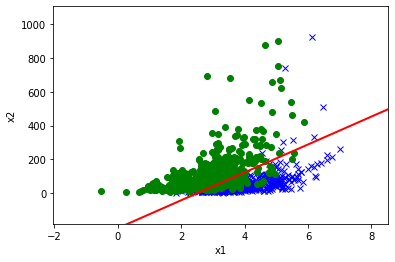

In [10]:
util.plot(x_train, y_train, lr.theta)
print('Model Coefficients:', lr.theta)
print('Training Set Accuracy:', lr.accuracy_score(y_train, lr.predict(x_train)))

We do the same thing with the test set.

Test Set Accuracy: 90.0


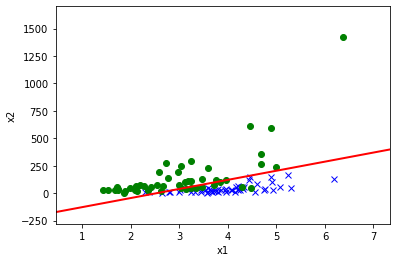

In [11]:
util.plot(x_eval, y_eval, lr.theta)
print('Test Set Accuracy:', lr.accuracy_score(y_eval, y_pred))

Lastly, we show the diminishing average empirical loss as we train the model.

Text(0, 0.5, 'Average Empirical Loss')

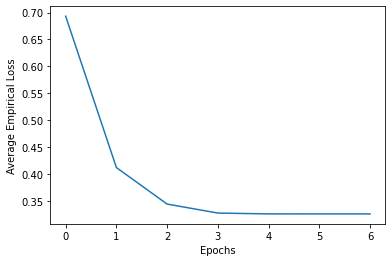

In [12]:
plt.plot(lr.losses_)
plt.xlabel('Epochs')
plt.ylabel('Average Empirical Loss')

### c)

We consider a Gaussian Discriminant Analysis where our model takes the following form:

\begin{align*}
p(y) &= \left\{ \begin{aligned} 
   &\phi \ \ \ \ \  \ \  \ \ \ \ \  \ \ \text{if} \ \  y = 1\\
  &(1 - \phi) \ \ \ \ \ \text{if} \ \  y = 0
\end{aligned} \right. \\
p(x|y = 0) &= \frac{1}{(2\pi)^{n/2} \ |\Sigma|^{-1/2}} \ \text{exp} \ (-\frac{1}{2}(x - \mu_0)^T \ \Sigma^{-1} \ (x - \mu_0)) \\
p(x|y = 0) &= \frac{1}{(2\pi)^{n/2} \ |\Sigma|^{-1/2}} \ \text{exp} \ (-\frac{1}{2}(x - \mu_1)^T \ \Sigma^{-1} \ (x - \mu_1))
\end{align*}

We want to show that GDA results in a linear classifier that has a linear decision boundary. In particular, we want to show that

\begin{align*}
p(y = 1|x; \phi, \mu_0, \mu_1, \Sigma) = \frac{1}{1 + \text{exp}(-\theta^Tx + \theta_0)}
\end{align*}

We start out with Bayes's Rule, and omit parameters in parentheses for simplicity:

\begin{align*}
p(y = 1|x) &= \frac{p(x|y = 1)p(y = 1)}{p(x|y = 1)p(y = 1) + p(x|y = 0)p(y = 0)} \\
&= \frac{\phi \ \text{exp} \ (-\frac{1}{2}(x - \mu_1)^T \ \Sigma^{-1} \ (x - \mu_1))}{\phi \ \text{exp} \ (-\frac{1}{2}(x - \mu_1)^T \ \Sigma^{-1} \ (x - \mu_1)) + (1 - \phi) \ \text{exp} \ (-\frac{1}{2}(x - \mu_0)^T \ \Sigma^{-1} \ (x - \mu_0))} \\
&= \frac{1}{1 + \frac{1 - \phi}{\phi} \ \text{exp} \ (\frac{1}{2}(x - \mu_1)^T \ \Sigma^{-1} \ (x - \mu_1)) - \frac{1}{2}(x - \mu_0)^T \ \Sigma^{-1} \ (x - \mu_0))} \\
&= \frac{1}{1 + \text{exp} \ (\frac{1}{2}(x - \mu_1)^T \ \Sigma^{-1} \ (x - \mu_1)) - \frac{1}{2}(x - \mu_0)^T \ \Sigma^{-1} \ (x - \mu_0) + \text{log}(\frac{1 - \phi}{\phi}))} \\
&= \frac{1}{1 + \text{exp} \ (-((\mu_1 - \mu_0)^T \ \Sigma^{-1}x + \frac{1}{2} \ (\mu_0^T \Sigma^{-1} \mu_0 - \mu_1^T \Sigma^{-1} \mu_1 - \text{log}(\frac{1 - \phi}{\phi}))))} \\
&= \frac{1}{1 + \text{exp}(-\theta^Tx + \theta_0)}
\end{align*}

### d)